# Main Class

Constraint: Decisioning to emit session must be run 
* every 60 units of time 
* i.e. Decision whether to emit a session or not must be trigger 
  * on reception of an input which timestamp is greater than 60 + the timestamp decision was previously run 
  * [Can also be thought of as every 60 seconds if input is timely].
* Bonus
  * Move algorithm to be entirely stream 
  * i.e. run decisioning logic after every input message.

In [26]:
import json

class Sessionizer():
    '''
    This class is used to instantiate an object for:
    1. Parsing and logging time stamped activity data points from standard input
    2. Detecting when an activity has been idle for sufficient time to treat it as a completed session.
    3. Prints sessions to standard output.
    '''
    
    def __init__(self, sessionIdleThreshold, debug=False):
        '''
        Selects the most probable activity represented by this event.
        
        Input
        =====
        sessionIdleThreshold -- How much idle time is required before a session is considered complete. 
        debug -- Makes operations more verbose when set to true.
        '''
        
        self.runningSessions = {}
        self.emittedSessions = []
        self.summedGoal = 0.0
        self.sessionIdleThreshold = sessionIdleThreshold
        self.debug = debug
        
    def getProbableActivity(self, activityList):
        '''
        Selects the most probable activity represented by this event.
        
        Input
        =====
        activityList -- Given a sample distribution over an activity space. 
        
        Output
        ======
        probablyActivity["id"] -- The ID of the most probable activity
        probableActivity["probability"] -- The probability of the most probable activity
        '''
        
        activityList.sort(key = lambda x: x["probability"], reverse=True)
        probableActivity = activityList[0]
        
        return probableActivity["id"], probableActivity["probability"]
    
    def parseInput(self, inputString):
        '''
        Reads a string from standard input
        
        Input
        =====
        inputString -- An activity event string.
        
        Output
        ======
        result -- A dict representation of the most probable even that occurred.
        '''
        
        inputObject = json.loads(inputString)

        # return the most probably activity
        deviceId = inputObject["deviceId"]
        ts = inputObject["timestamp"]
        probableActivity, probability = self.getProbableActivity(inputObject["activity"])
        
        result={
            "deviceId" : int(deviceId),
            "timestamp" : int(ts),
            "activity" : int(probableActivity),
            "probability" : float(probability)
        }
        
        if self.debug:
            print("parseInput")
            print(result)
        
        return result
    
    def logSessions(self, dataPoint):
        '''
        Reads an activity event on a device, summarizes it and stores it as an inprogress session.
        The first time the activity was observed and the most recent time the activity was observed is stored.
        Also, running totals of:
        - the number of data points in the session
        - the sum of reciprocal probabilites
        
        are stored stored so that the harmonic mean can be computed when 
        
        Input
        =====
        dataPoint -- A dict representation of the most probable even that occurred.
        '''
        
        # Create new record if this is a new device
        if self.runningSessions.get(dataPoint["deviceId"]) == None:
            self.runningSessions[dataPoint["deviceId"]] = {}
        
        # If this is a new activity for the device create a new running session representation of it
        if self.runningSessions[dataPoint["deviceId"]].get(dataPoint["activity"]) == None:
            self.runningSessions[dataPoint["deviceId"]][dataPoint["activity"]] = {"minTs": dataPoint["timestamp"],
                                                                                "maxTs": dataPoint["timestamp"],
                                                                                 "numObservations": 1,
                                                                                 "sumReciprocals": 1./dataPoint["probability"]
                                                                                 }

        # If the Record exists update the running session
        else:  
            # Update max time, numObservations, sumReciprocals
            self.runningSessions[dataPoint["deviceId"]][dataPoint["activity"]]["maxTs"] = dataPoint["timestamp"]
            self.runningSessions[dataPoint["deviceId"]][dataPoint["activity"]]["numObservations"] += 1
            self.runningSessions[dataPoint["deviceId"]][dataPoint["activity"]]["sumReciprocals"] += 1./dataPoint["probability"]
            
        if self.debug:
            print("logSessions")
            print(self.runningSessions[dataPoint["deviceId"]][dataPoint["activity"]])

    def emitSession(self, deviceId, activityId, tuningMode):
        '''
        Calculates the session score and goal score if it is time to emit the running session.
        Removes the completed session from the running sessions data structure.
        Prints the session to standard out as a dictionary.
        In debug mode, also returns the completed session as a dictionary for debugging purposes.
        
        Input
        =====
        dataPoint -- A dict representation of the most probable even that occurred.
        '''
        
        sessionState = self.runningSessions[deviceId][activityId]
        
        duration = sessionState["maxTs"] - sessionState["minTs"]
        harmonicMean = sessionState["numObservations"] / sessionState["sumReciprocals"]
        score = duration**2 * harmonicMean
        
        result = {
            "deviceId": deviceId,
            "activity": activityId,
            "minTs" : sessionState["minTs"],
            "maxTs" : sessionState["maxTs"],
            "duration" : duration,
            "harmonicMean" : harmonicMean,
            "score" : score
        }
        
        # remove session info for the removed session
        self.runningSessions[deviceId].pop(activityId)
        if len(self.runningSessions.get(deviceId)) == 0:
            self.runningSessions.pop(deviceId)
        
        # Save goal score
        self.summedGoal += result["score"]
        
        if self.debug | (tuningMode == False):
            print("Emit Session:")
            
        outputString = "D%i\t\t%i\t\t%i\t\tA%i\t\t[%.2f|%.2e]" % (result["deviceId"],
                                                         result["minTs"],
                                                         result["maxTs"],
                                                         result["activity"],
                                                         result["harmonicMean"],
                                                         result["score"])    
        if tuningMode == False:
            print(outputString)
            
        return result
        
    def decideEmitSession(self, processedData, sessionIdleThreshold):
        '''
        Decides if it any running sessions are complete and need to be emitted as completed sessions.
        Makes a list of them.
        
        Input
        =====
        processedData -- The newest data point read in from standard input.
        sessionIdleThreshold -- The amount of time a session must be idle before it is considered complete.
        
        Output
        ======
        emitSessionList -- A list of deviceId, activityId pairs that represent sessions that should be emitted.
        '''

        currentTime = processedData["timestamp"]
        
        emitSessionList = []
        
        # Traverse running sessions data structure. 
        # If a session has been idle add it to the list of sessions
        for deviceId, activities in list(self.runningSessions.items()):
            for activityId, runningSession in list(activities.items()):
                idleDuration  = currentTime - runningSession["maxTs"]
                
                if (idleDuration) >= sessionIdleThreshold:  
                    if self.debug:
                        print("emit session")
                        print("\tcurrent time = %i" % currentTime)
                        print("\tsession last time = %i" % runningSession["maxTs"])
                        print("\tidle duration = %i" % idleDuration)
                        print("\tidle threshold = %i" % sessionIdleThreshold)
                    emitSessionList.append((deviceId, activityId))

        return emitSessionList
                    
        
    def listen(self, inputFunction = None, tuningMode=False):
        '''
        This loop listens on standard in for new input events. It parses incoming events for storage as running sessions.
        Once the running sessions are considered complete, they are emitted to standard output.
        
        If the debug class variable is set, all emitted Sessions will be stored in the emittedSessions variable for 
        debugging and analysis.
        
        Input
        =====
        inputFunction -- Allows a readline function to be passed in so that a string or file of input events can be read in
            line by line to from standard input. If an inputFunction is not specified, the listen function will expect the
            user to enter each individual activity event at the standard input prompt.
        
        Output
        ======
        emitSessionList -- A list of deviceId, activityId pairs that represent sessions that should be emitted.
        '''
        
        # Print header
        if tuningMode == False:
            print("=" * 100)
            print("DeviceId\tFrom\t\tTo\t\tActivity\t[Score]")
          
        while True:
            if inputFunction is None:
                inputString=input("> ")
            else:
                inputString = inputFunction()
            
            if not inputString: 
                if not tuningMode:
                    print("=" * 100)
                    print("EOF received, terminating")

                break

            processedData = self.parseInput(inputString)
            
            # Assess whether any sessions need to be emitted
            emitList = self.decideEmitSession(processedData, self.sessionIdleThreshold)
            
            for deviceId, activityId in emitList:
                emittedSession = self.emitSession(deviceId, activityId, tuningMode=tuningMode)
                if self.debug | tuningMode:
                    self.emittedSessions.append(emittedSession)
            
            # log new data point
            self.logSessions(processedData)            

# Create data for standard input

This data was provided as an example.

In [27]:
import io

sampleDataString = """{ "deviceId" : "1", "timestamp": "1",  "activity" : [{"id": "1", "probability": 1}]}
{ "deviceId" : "1", "timestamp": "12", "activity" : [{"id": "1", "probability": 1}]}
{ "deviceId" : "1", "timestamp": "15", "activity" : [{"id": "1", "probability": 0.9}, {"id": "2", "probability": 0.1}]}
{ "deviceId" : "1", "timestamp": "17", "activity" : [{"id": "1", "probability": 1}]}
{ "deviceId" : "1", "timestamp": "50", "activity" : [{"id": "1", "probability": 0.5}, {"id": "2", "probability": 0.5}]}
{ "deviceId" : "1", "timestamp": "51", "activity" : [{"id": "2", "probability": 1}]}
{ "deviceId" : "1", "timestamp": "60", "activity" : [{"id": "2", "probability": 1}]}
{ "deviceId" : "1", "timestamp": "70", "activity" : [{"id": "2", "probability": 1}]}
{ "deviceId" : "1", "timestamp": "85", "activity" : [{"id": "2", "probability": 1}]}
{ "deviceId" : "1", "timestamp": "97", "activity" : [{"id": "2", "probability": 1}]}
{ "deviceId" : "1", "timestamp": "109","activity" : [{"id": "2", "probability": 1}]}
{ "deviceId" : "1", "timestamp": "120","activity" : [{"id": "2", "probability": 1}]}
{ "deviceId" : "2", "timestamp": "300","activity" : [{"id": "3", "probability": 1}]}
"""


inputFile = io.StringIO(sampleDataString)

# Tune idle time threshold

Try a number of thresholds and see which one yields the best overal goal score on our sample data.

In [28]:
idleThresholds = range(1,200)

results = []
for threshold in idleThresholds:

    inputFile = io.StringIO(sampleDataString)
    
    sessionManager = Sessionizer(sessionIdleThreshold = threshold, debug=False)

    # Start listening for events
    sessionManager.listen(inputFile.readline, tuningMode=True)
    
    results.append((threshold, sessionManager.summedGoal, len(sessionManager.emittedSessions)))

### Plot the results to aid in interpretation

The plot and suggests that 34 is the threshold that optimizes maximum goal score with the largest number of sessions.

Optimal Idle Threshold = 34


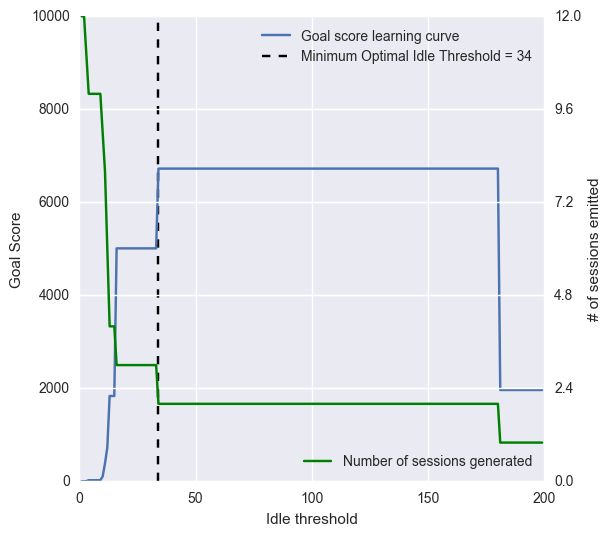

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plotThresholdScores(thresholdScores):
    x = [threshold for threshold, score, numSessions in thresholdScores]
    y = [score for threshold, score, numSessions in thresholdScores]
    numSessions = [numSessions for threshold, score, numSessions in thresholdScores]
    
    minOptimalThreshold = x[y.index(max(y))]
    
    fig, ax1 = plt.subplots(figsize=(6,6))
    ax1.plot(x,y, label="Goal score learning curve")
    ax1.vlines(x=minOptimalThreshold, ymin=0, ymax = 10000, 
               linestyles = "dashed",
               label="Minimum Optimal Idle Threshold = %i" % minOptimalThreshold)
    
    ax2 = ax1.twinx()
    ax2.plot(x,numSessions, label="Number of sessions generated", color="green")
    ax2.set_yticks(np.linspace(ax2.get_yticks()[0],ax2.get_yticks()[-1],len(ax1.get_yticks())))
    
    ax1.set_xlabel("Idle threshold")
    ax1.set_ylabel("Goal Score")
    ax2.set_ylabel("# of sessions emitted")
    
    ax1.legend(loc="upper right")
    ax2.legend(loc="lower right")
    
    return minOptimalThreshold

optimalIdleTime = plotThresholdScores(results)
print("=" *50)
print("Optimal Idle Threshold = %i" % optimalIdleTime)

# Run sessionizer with optimal idle time

In [30]:
inputFile = io.StringIO(sampleDataString)

sessionManager = Sessionizer(sessionIdleThreshold = optimalIdleTime, debug=False)

# Start listening for events
print("=" * 50)
print("Listen for events and emit sessions:")
sessionManager.listen(inputFile.readline)

print("=" * 50)
print("Goal function sum = %.2e" % sessionManager.summedGoal)
print("\n")

Listen for events and emit sessions:
DeviceId	From		To		Activity	[Score]
Emit Session:
D1		1		50		A1		[0.82|1.96e+03]
Emit Session:
D1		51		120		A2		[1.00|4.76e+03]
EOF received, terminating
Goal function sum = 6.73e+03


